<a href="https://colab.research.google.com/github/yelim421/SolarPower/blob/main/all_data_TabNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd /content/drive/MyDrive/Solar_Power

/content/drive/MyDrive/Solar_Power


In [61]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 18 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 3s (3,329 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 120895 files and dire

In [3]:
import matplotlib.pyplot as plt # 맷플롯립 import 하기
plt.rcParams['font.family'] = 'NanumBarunGothic'

In [4]:
import os
import glob
from joblib import Parallel, delayed
import pandas as pd
import numpy as np
import scipy as sc
from sklearn.model_selection import KFold
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler
import random
from sklearn.metrics import mean_absolute_error
from scipy.stats import pearsonr

In [5]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [6]:
SEED = 42

def random_seed(SEED):

    random.seed(SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(SEED)
        torch.cuda.manual_seed_all(SEED)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

random_seed(SEED)

In [18]:
!pip install pytorch-tabnet

In [20]:
!make start-gpu

make: *** No rule to make target 'start-gpu'.  Stop.


In [7]:
from pytorch_tabnet.pretraining import TabNetPretrainer
from pytorch_tabnet.tab_model import TabNetRegressor
from pytorch_tabnet.metrics import Metric
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

import pandas as pd
import numpy as np
np.random.seed(0)


import os
from pathlib import Path

In [8]:
def calculate_pearsonr(data1, data2):
    return pearsonr(data1, data2)

In [9]:
def preprocess_data():
    all_data = pd.read_csv('asos_train.csv', encoding='cp949')

#     ['영암에프원태양광b', '[서인천]발전부지내 태양광 1단계', '[서인천]발전부지내 태양광 1단계ESS',
#        '[서인천]발전부지내 태양광 2단계', '군산복합2단계태양광', '군산복합2단계태양광ESS', '대전 학하 연료전지',
#        '삼랑진태양광#1', '삼랑진태양광#2', '서인천연료전지', '서인천연료전지2',
#        '세종시수질복원센터태양광연계 ESS', '수질복원센터태양광', '의왕 연료전지', '장흥풍력', '천안청수연료전지']

    relevant_loc = ['영암에프원태양광b','[서인천]발전부지내 태양광 1단계','[서인천]발전부지내 태양광 2단계',
                    '삼랑진태양광#1', '삼랑진태양광#2', '수질복원센터태양광']

    all_data = all_data[all_data['name'].isin(relevant_loc)]

    all_data.fillna(-1, inplace=True)

    all_data['date'] = pd.to_datetime(all_data['date'])
    all_data['year'] = all_data['date'].dt.year
    all_data['month'] = all_data['date'].dt.month
    all_data['hour'] = all_data['date'].dt.hour


    # Index(['power', 'date', 'name', 'capacities', 'asos_num', 'land', 'power/land',
    #        'location', 'Date/Time', 'Temp(C)', 'Prec(mm)', 'Wind_speed(m/s)',
    #        'Wind_Direction(16 compass points)', 'Humidity', 'Vapor_pressure(hPa)',
    #        'Dew_Point(C)', 'Local Atmospheric Pressure(hPa)',
    #        'Sea-level_Pressure(hPa)', 'sunshine(hr)', 'Solar_Radiation(MJ/m2)',
    #        'Snowfall(cm)', '3-hour_Fresh_Snowfall', 'Cloud_Cover(1/10)',
    #        'Mid-Low_Cloud_Cover', 'Cloud_Form', 'Lowest_Cloud_Height(100m)',
    #        'Visibility(10m)', 'Ground_Condition', 'Phenomenon_Number',
    #        'Ground Temp', '5cm_Underground_Temp', '10cm_Underground_Temp',
    #        '20cm_Underground_Temp', '30cm_Underground_Temp'],
    #       dtype='object')

    drop_columns = [ "asos_num", "location", "power", "capacities", "land",
                   'Wind_Direction(16 compass points)', 'Humidity', 'Vapor_pressure(hPa)', "Date/Time",
                    'Local Atmospheric Pressure(hPa)',
                   'Sea-level_Pressure(hPa)',
                   '3-hour_Fresh_Snowfall',
                   'Mid-Low_Cloud_Cover', 'Cloud_Form', 'Lowest_Cloud_Height(100m)',
                   'Visibility(10m)', 'Ground_Condition', 'Phenomenon_Number',
                   'Ground Temp', '5cm_Underground_Temp', '10cm_Underground_Temp',
                   '20cm_Underground_Temp', '30cm_Underground_Temp']

    all_data = all_data.drop(columns=drop_columns)

    all_data_train = all_data[all_data['year'].isin([2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020])]
    all_data_test = all_data[all_data['year'].isin([2021,2022])]


    train_data_no_time = all_data_train.drop(columns=['date','name'])
    test_data_no_time = all_data_test.drop(columns=['date', 'name'])

    scaler = MinMaxScaler()

    train_scaled_array = scaler.fit_transform(train_data_no_time.values.astype('float32'))

    test_scaled_array = scaler.transform(test_data_no_time.values.astype('float32'))

    train_scaled_df = pd.DataFrame(train_scaled_array, columns=train_data_no_time.columns)
    test_scaled_df = pd.DataFrame(test_scaled_array, columns=test_data_no_time.columns)

    all_data_train = all_data_train[['name', 'date']].reset_index(drop=True)
    train_scaled_df = train_scaled_df.reset_index(drop=True)
    all_data_train = pd.concat([all_data_train, train_scaled_df], axis=1)

    all_data_test = all_data_test[['name', 'date']].reset_index(drop=True)
    test_scaled_df = test_scaled_df.reset_index(drop=True)
    all_data_test = pd.concat([all_data_test, test_scaled_df], axis=1)

    all_data_train.sort_values(by=['name', 'date'], inplace=True)
    all_data_test.sort_values(by=['name', 'date'], inplace=True)

    return all_data_train, all_data_test

In [10]:
import pandas as pd

def create_folds(data, num_splits, date_column):
    # Create a new column called kfold and fill it with -1
    data["kfold"] = -1

    # Sort the data based on the date column
    data = data.sort_values(by=date_column).reset_index(drop=True)

    # Initialize TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=num_splits)

    # Assign fold numbers using TimeSeriesSplit
    for fold, (train_idx, test_idx) in enumerate(tscv.split(data)):
        data.loc[test_idx, "kfold"] = fold

    return data

#                       min                 max
# kfold
# -1    2013-03-19 07:00:00 2015-12-28 14:00:00
#  0    2015-12-28 15:00:00 2018-03-08 18:00:00
#  1    2018-03-08 18:00:00 2018-09-15 08:00:00
#  2    2018-09-15 09:00:00 2019-04-29 09:00:00
#  3    2019-04-29 09:00:00 2019-11-06 17:00:00
#  4    2019-11-06 18:00:00 2020-12-31 19:00:00

In [11]:
def mape(y_true, y_pred):
  if (y_true == 0).any():
    raise ValueError("y_true is zero")
    loss = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return loss

class MAPE(Metric):
  def __init__(self):
    self._name = "mape"
    self._maximize = False

  def __call__(self, y_true, y_score):
    return mape(y_true, y_score)

In [12]:
tabnet_params = dict(
    n_d = 32,
    n_a = 32,
    n_steps = 3,
    gamma = 1.3,
    lambda_sparse = 0,
    optimizer_fn = optim.Adam,
    optimizer_params = dict(lr = 1e-2, weight_decay = 1e-5),
    mask_type = "entmax",
    scheduler_params = dict(
        mode = "min", patience = 5, min_lr = 1e-5, factor = 0.9),
    scheduler_fn = ReduceLROnPlateau,
    seed = 42,
    verbose = 5,
)

In [38]:
max_epochs = 300

In [51]:
train, test = preprocess_data()
train = train[train["power/land"] != 0].reset_index(drop = True)

In [ ]:
train.head()

In [40]:
bestscores = []

train["date"] = pd.to_datetime(train["date"])

traindf = train[train["date"].dt.year != 2020].reset_index(drop = True)
validdf = train[train["date"].dt.year == 2020].reset_index(drop = True)

X_train = traindf.drop(['name', 'date', 'power/land'], axis = 1).values
y_train = traindf['power/land'].values.reshape(-1,1)

X_valid = validdf.drop(['name', 'date', 'power/land'], axis = 1).values
y_valid = validdf['power/land'].values.reshape(-1,1)

print(X_train.shape)
print(X_valid.shape)

#calculate weight
y_weight = 1/np.square(traindf["power/land"])

random_seed(SEED)

clf = TabNetRegressor(**tabnet_params) #**tabnet_params

clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'],
    eval_metric=['rmsle', 'mae', 'rmse', 'mse'],
    max_epochs=max_epochs,
    patience=50,
    batch_size=1024,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False,
    weights = y_weight,
    loss_fn=nn.L1Loss()
)

saving_path_name = "tabnet_model_test_"
saved_filepath = clf.save_model(saving_path_name)

bestscores.append(clf.best_cost)


(65091, 11)
(9594, 11)
Device used : cuda
epoch 0  | loss: 0.15887 | train_rmsle: 0.09565000236034393| train_mae: 0.31782999634742737| train_rmse: 0.4050999879837036| train_mse: 0.164110004901886| valid_rmsle: 0.08761999756097794| valid_mae: 0.2960900068283081| valid_rmse: 0.38710999488830566| valid_mse: 0.14985999464988708|  0:00:04s


KeyboardInterrupt: ignored

In [ ]:
bestscores

# [0.03991734, 0.039965607, 0.085949, 0.08679309] k-fold나눴을 때

In [ ]:
print("cv average is ",str(np.mean(bestscores)))

# cv average is  0.06315626 k-fold 나눴을 때

In [49]:
#modelpath = [os.path.join("./",s) for s in os.listdir("./") if ("zip" in s)]
modelpath = ['./tabnet_model_test_1.zip',
 './tabnet_model_test_2.zip',
 './tabnet_model_test_3.zip',
 './tabnet_model_test_4.zip']

In [52]:
x_test = test.drop(['name', 'date', 'power/land'], axis = 1).values
preds = []

for path in modelpath:

  clf.load_model(path)
  preds.append(clf.predict(x_test).squeeze(-1))

preds = np.mean(preds, axis = 0)
test['pred'] = preds
test.head()

Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda


,name,date,power/land,Temp(C),Prec(mm),Wind_speed(m/s),Dew_Point(C),sunshine(hr),Solar_Radiation(MJ/m2),Snowfall(cm),Cloud_Cover(1/10),year,month,hour,pred
17102,[서인천]발전부지내 태양광 1단계,2021-01-01 09:00:00,0.038017,0.197080,0.000000,0.148352,0.306349,0.75,0.244161,0.0,0.727273,1.142853,0.0,0.1875,0.053789
17103,[서인천]발전부지내 태양광 1단계,2021-01-01 10:00:00,0.185052,0.231752,0.000000,0.186813,0.312698,1.00,0.350318,0.0,0.272727,1.142853,0.0,0.2500,0.168937
17104,[서인천]발전부지내 태양광 1단계,2021-01-01 11:00:00,0.107373,0.266423,0.000000,0.181319,0.330159,1.00,0.467091,0.0,0.272727,1.142853,0.0,0.3125,0.257776
17105,[서인천]발전부지내 태양광 1단계,2021-01-01 12:00:00,0.099975,0.284672,0.023474,0.197802,0.360317,1.00,0.526539,0.0,0.636364,1.142853,0.0,0.3750,0.286400
17106,[서인천]발전부지내 태양광 1단계,2021-01-01 13:00:00,0.099051,0.308394,0.000000,0.208791,0.374603,1.00,0.573248,0.0,0.272727,1.142853,0.0,0.4375,0.338993


Testing for location [서인천]발전부지내 태양광 1단계...
(5472,) (5472,)
mae is 0.222414031624794


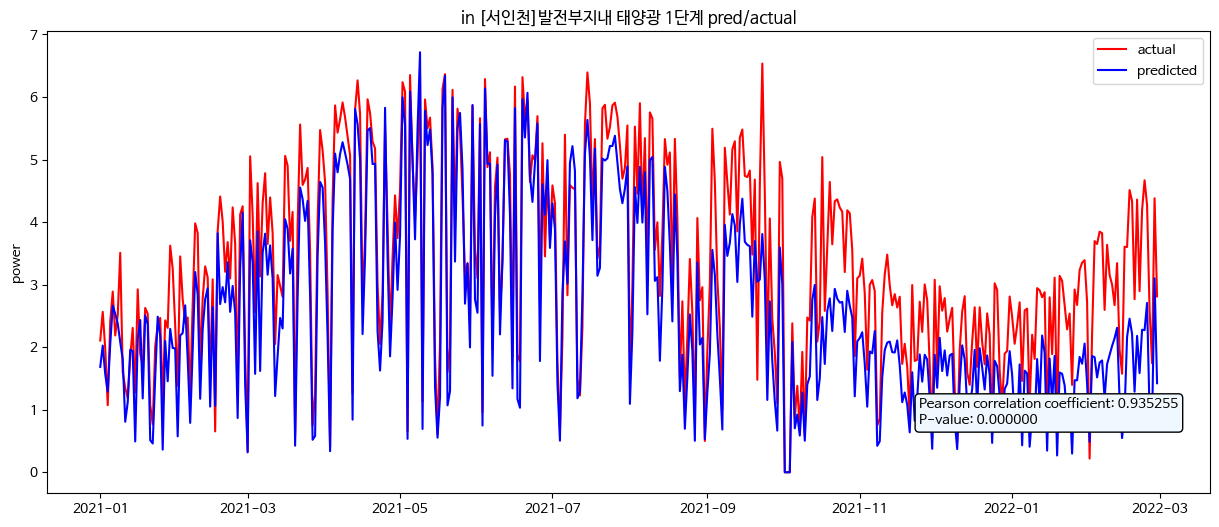

Testing for location [서인천]발전부지내 태양광 2단계...
(4838,) (4838,)
mae is 0.10858999192714691


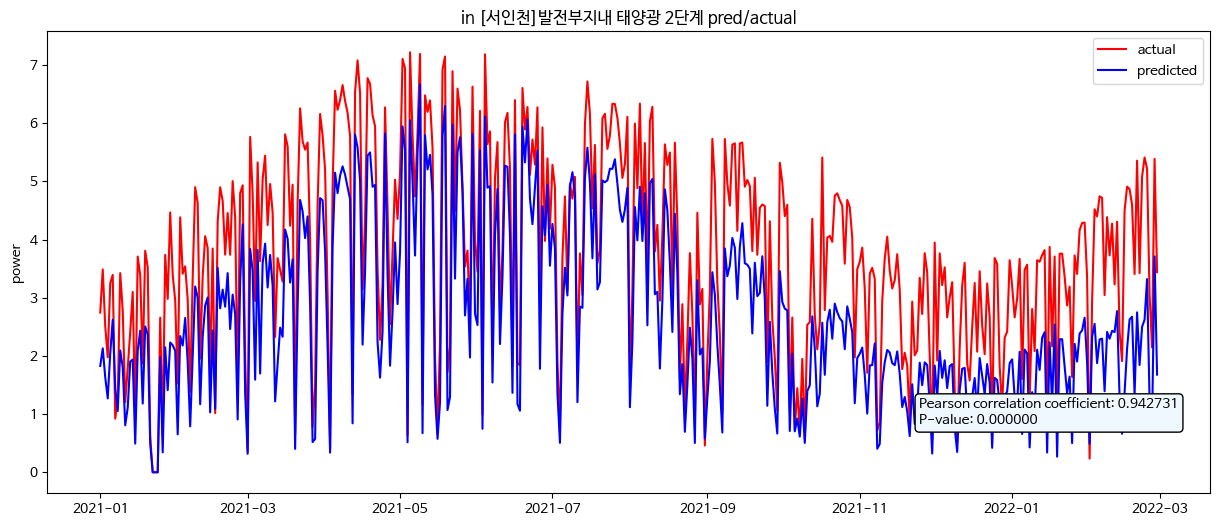

Testing for location 삼랑진태양광#1...
(4959,) (4959,)
mae is 0.2751607596874237


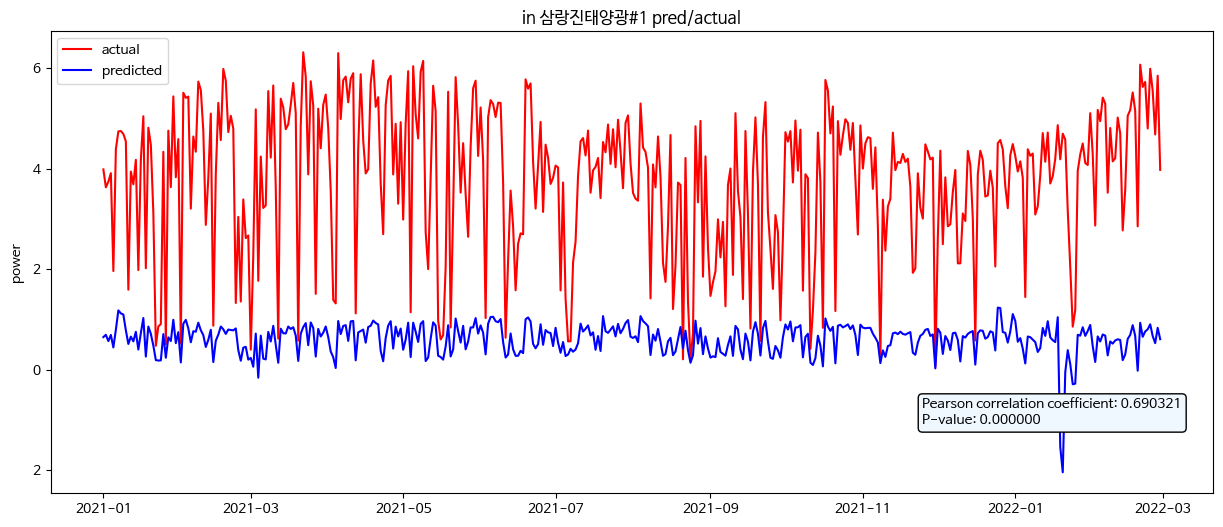

Testing for location 삼랑진태양광#2...
(5077,) (5077,)
mae is 0.2825663089752197


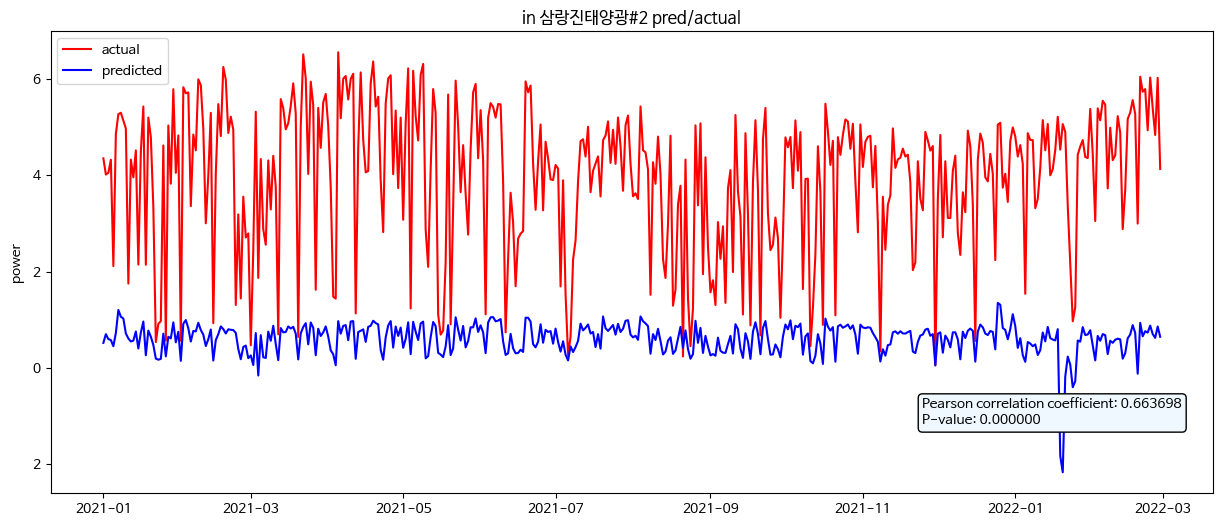

Testing for location 수질복원센터태양광...
(6140,) (6140,)
mae is 0.21891428530216217


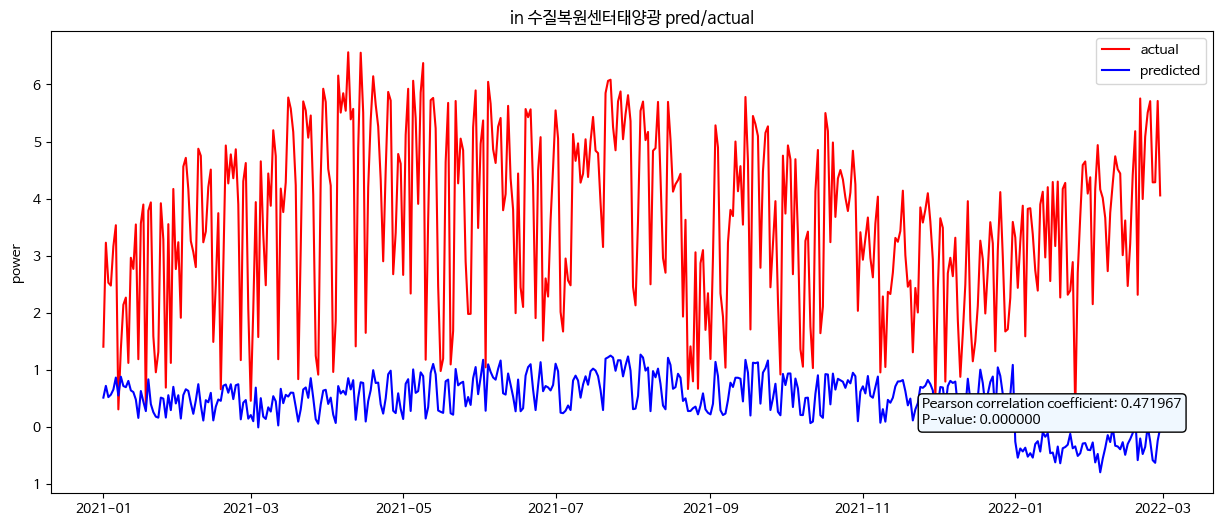

Testing for location 영암에프원태양광b...
(8934,) (8934,)
mae is 0.11217441409826279


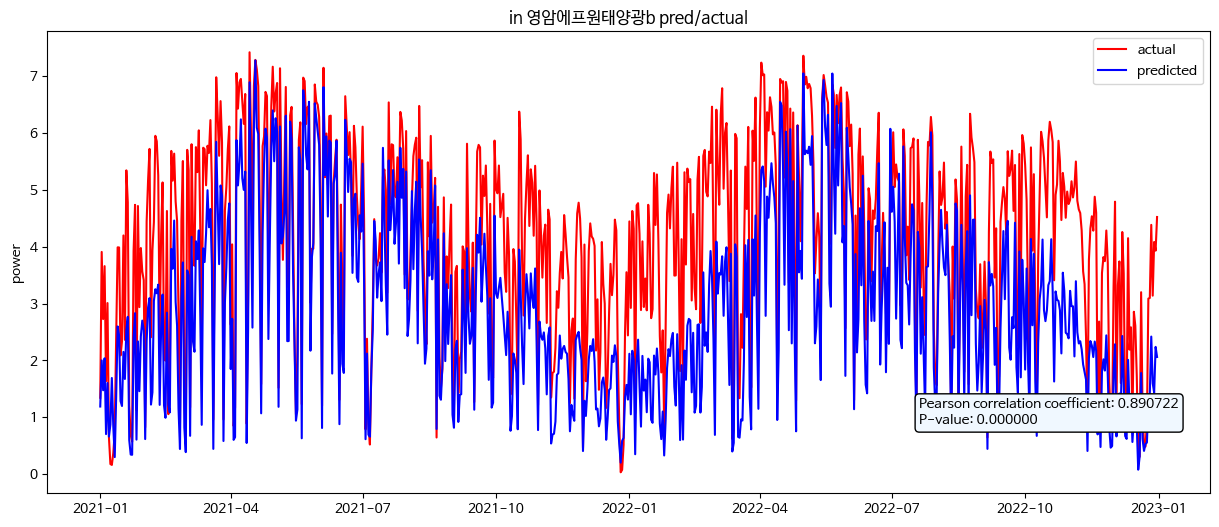

In [53]:
for location in test['name'].unique():
    print(f"Testing for location {location}...")

    location_data = test[test['name']==location]
    pred = location_data['pred']
    actual = location_data['power/land']
    print(pred.shape, actual.shape)
    mae = mean_absolute_error(actual, pred)
    print(f"mae is {mae}")

    location_data['date'] = pd.to_datetime(location_data['date'])
    location_data.set_index('date', inplace = True)

    daily_actual_sum = location_data.resample('D').sum()['power/land']
    daily_predicted_sum = location_data.resample('D').sum()['pred']

    corr_coefficient, p_value = calculate_pearsonr(daily_actual_sum, daily_predicted_sum)

    plt.figure(figsize=(15,6))
    plt.plot(daily_actual_sum, label = 'actual', color = 'red')
    plt.plot(daily_predicted_sum, label = 'predicted', color = 'blue')
    plt.title(f"in {location} pred/actual")
    plt.ylabel('power')
    plt.legend()

    corr_text = f"Pearson correlation coefficient: {corr_coefficient:.6f}\nP-value: {p_value:.6f}"
    plt.annotate(corr_text, xy=(0.75, 0.15), xycoords='axes fraction', fontsize=10, bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="aliceblue"))

    plt.show()